In [1]:
#Per Patient Total Probablity of Prediction X axis, probablility, Y axis the frequency
#Can split true 0 as X and true 1 as oh's, and split by color for ga2m versus logistic regression etc.

#Graphs the difference in percentage between the ga2m and the logistic per patient

#Can Also test across time

#Dataset: Should be able to handle any

import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline
from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.perf import ROC
from interpret.glassbox import LogisticRegression, ClassificationTree
#without the class structure single shot each time
from interpret import show
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.perf import ROC
from interpret.glassbox import LogisticRegression, ClassificationTree
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error



In [2]:
#Upload Data and Data Cleanup

df = pd.read_csv("/Users/gabrielalon/Desktop/heartdisease.csv")
df.columns = [
    "male","age","education","currentSmoker","cigsPerDay","BPMeds","prevalentStroke","prevalentHyp","diabetes","totChol","sysBP","diaBP","BMI","heartRate","glucose","TenYearCHD"
]
print("Nan missing values by column")
#Number of Nans by column
missing_val_count_by_column = (df.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])
print(len(df))

Nan missing values by column
education     105
cigsPerDay     29
BPMeds         53
totChol        50
BMI            19
heartRate       1
glucose       388
dtype: int64
4240


In [3]:
#Common practice to fill in the mean of the empty values for prediction algorithm to work
df.fillna(df.mean(), inplace=True)
missing_val_count_by_column = (df.isnull().sum())
print("No Missing values remaining if empty below")
print(missing_val_count_by_column[missing_val_count_by_column > 0])
print(len(df))

No Missing values remaining if empty below
Series([], dtype: int64)
4240


In [4]:
#Alternative to filling in the mean is to drop the NaN rows

#print(missing_val_count_by_column[missing_val_count_by_column > 0])
#df.dropna(axis=0,inplace=True)
#print("No Missing values remaining if empty below")
#missing_val_count_by_column = (df.isnull().sum())
#print(len(df))


In [5]:
def splitting(df):
    df = df
    train_cols = df.columns[0:-1]
    label = df.columns[-1]
    X = df[train_cols]
    y = df[label] 
    #y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1
    seed = 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
    return [X_train, y_train, X_test, y_test, X, y]
        

In [6]:
split_data = splitting(df)
X_train = split_data[0] 
y_train = split_data[1]
X_test = split_data[2] 
y_test = split_data[3]
X = split_data[4]
y = split_data[5]

In [7]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_global = ebm.explain_global()
#show(ebm_global)

In [8]:
hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')
#show(hist)
seed = 1
#To specificy specific interaction pairs
#ebm = ExplainableBoostingClassifier(random_state=seed)
#ebm = ExplainableBoostingClassifier(interactions=[[0, 1], [2, 3]])
#To just have a certain number of interaction pairs
ebm = ExplainableBoostingClassifier(interactions=1, random_state=seed)
ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays
ebm_global = ebm.explain_global(name='EBM')
# show(ebm_global)
print(ebm.intercept_, "The intercept in the model known as the baseline \n")
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')
print(ebm_local.data(1)['perf'])
print('predicted' ,ebm_local.data(1)['perf']['predicted'])
#show(ebm_local)
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
#show(ebm_perf)
#Length of available data in ebm_local.data is only in the test set???


-1.9332242618014839 The intercept in the model known as the baseline 

{'actual': 0, 'predicted': 0.09660036229535049, 'residual': -0.09660036229535049}
predicted 0.09660036229535049


In [9]:
#find a way to actually refer directly to the iterable range
#print((ebm_local.data(84)))
list_predicted_ebm = []
ground_truth_ebm = []
ebm_len = len(y_test)
for i in range(ebm_len):
    list_predicted_ebm.append(ebm_local.data(i)['perf']['predicted'])
    ground_truth_ebm.append(ebm_local.data(i)['perf']['actual'])

In [10]:
#validating that the ground truth are the same
#print(list_predicted_ebm)
#print(ground_truth_ebm)
#print((y_test.iloc[0:-1]))

for i in range(len(y_test)):
    if (y_test.iloc[i]) == (ebm_local.data(i)['perf']['actual']):
        pass
    else:
        print("fail")

In [11]:
#Training the other models below
# We have to transform categorical variables to use Logistic Regression and Decision Tree
seed=1
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = X_enc.columns

X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)

#logistic regression
lr = LogisticRegression(random_state=seed, feature_names=feature_names, penalty='l1')
lr.fit(X_train_enc, y_train)
lr_perf = ROC(lr.predict_proba).explain_perf(X_test_enc, y_test, name='Logistic Regression')
#help(lr)
#Classification Tree
tree = ClassificationTree()
tree.fit(X_train_enc, y_train)
tree_perf = ROC(tree.predict_proba).explain_perf(X_test_enc, y_test, name='Classification Tree')
 #show(lr_perf)
#show(tree_perf)
#show(ebm_perf)
#print(lr.__abstractmethods__)
#print(lr.__dict__)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
#probs = lr.predict_proba(X_enc)
probs = lr.predict_proba(X_test_enc)
print(probs[0][1])
list = []
for key in probs:
    list.append(key)
print(len(list), "next")
newlist = []
for i in (list):
    newlist.append((i[1]))
print(len(newlist))
print(len(list_predicted_ebm))
  #  print(list[i])
#The first index refers to the probability that the data belong to class 0,
#and the second refers to the probability that the data belong to class 1

0.07945077665327925
848 next
848
848


# Why the off by one error?

#diff = list_predicted_ebm-x
print(len(list_predicted_ebm))
print(len(x))


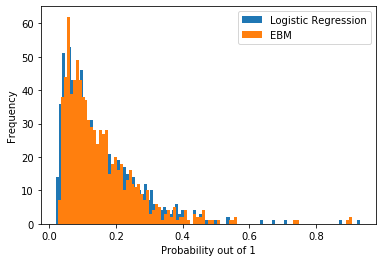

In [13]:
x = newlist
fig, ax = plt.subplots()
ax.hist(x, 100, label='Logistic Regression')
ax.hist(list_predicted_ebm, 100, label='EBM')
#plt.hist(list_predicted_ebm, bins = 100, label='$y = numbers')
ax.set_ylabel('Frequency')
ax.set_xlabel('Probability out of 1')
ax.legend()

#Why is there so much more data for the logistic regression???!

#Note you can't see which sample person is the same across each model

Text(0.5, 0, 'Difference in Probability out of 1')

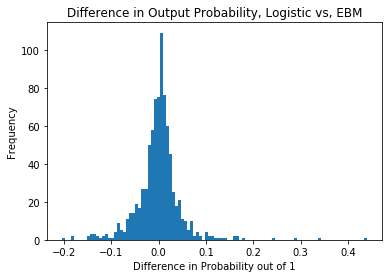

In [14]:
subtracted = [list_predicted_ebm-x for list_predicted_ebm, x in zip(list_predicted_ebm,x)]
fig, axs = plt.subplots()

axs.hist(subtracted, bins = 100)
axs.set_title('Difference in Output Probability, Logistic vs, EBM')
axs.set_ylabel('Frequency')
axs.set_xlabel('Difference in Probability out of 1')

In [15]:
#Checking to see if the examples where EBM and Logistic Disagree the most 
#ie: by more than 10% probability, how often was each model closer to the truth in the dataset

In [16]:
ebm_wins = 0
logistic_wins = 0
y_test_index = y_test.tolist()
for i in range(len(subtracted)):
    if subtracted[i] > 0.1:
        print("patient #", i, "disagreement of", 
        round(subtracted[i]*100,2),'%', 'EBM:', round(list_predicted_ebm[i]*100,2), 'logistic', round((x[i]*100),2), 'ground truth', y_test_index[i])
        if abs(list_predicted_ebm[i]-y_test_index[i]) < abs(x[i]-y_test_index[i]):
          #  print('EBM was closer above')
            ebm_wins +=1
        else:
            logistic_wins +=1

patient # 13 disagreement of 28.83 % EBM: 45.33 logistic 16.5 ground truth 0
patient # 42 disagreement of 13.74 % EBM: 50.51 logistic 36.77 ground truth 0
patient # 92 disagreement of 11.34 % EBM: 37.24 logistic 25.9 ground truth 1
patient # 169 disagreement of 13.24 % EBM: 40.94 logistic 27.7 ground truth 0
patient # 252 disagreement of 18.17 % EBM: 89.31 logistic 71.14 ground truth 1
patient # 287 disagreement of 10.4 % EBM: 37.3 logistic 26.9 ground truth 1
patient # 344 disagreement of 16.64 % EBM: 47.57 logistic 30.93 ground truth 1
patient # 429 disagreement of 16.77 % EBM: 41.04 logistic 24.27 ground truth 0
patient # 437 disagreement of 10.75 % EBM: 18.49 logistic 7.75 ground truth 0
patient # 489 disagreement of 12.73 % EBM: 38.72 logistic 25.99 ground truth 0
patient # 504 disagreement of 16.22 % EBM: 25.45 logistic 9.22 ground truth 0
patient # 529 disagreement of 10.48 % EBM: 25.44 logistic 14.95 ground truth 0
patient # 550 disagreement of 34.06 % EBM: 55.97 logistic 21.91

In [17]:
print("observe which number is bigger by how much")
print(ebm_wins, 'ebm wins: when it was closer to the truth')
print(logistic_wins, 'logistic wins: when it was closer to the truth')

observe which number is bigger by how much
7 ebm wins: when it was closer to the truth
14 logistic wins: when it was closer to the truth


In [18]:
#The format z-1:z shows you datapoint z
ebm_local = ebm.explain_local(X_test[13:14], y_test[13:14], name='EBM')
show(ebm_local)

<!-- http://127.0.0.1:7624/112077729520/ -->

In [19]:
#The format z-1:z shows you datapoint z
#Observing the Per Explanatory Variable graphs for each of those key patients 
lr_local =lr.explain_local(X_test[13:14], y_test[13:14], name='lr')
show(lr_local)



<!-- http://127.0.0.1:7624/112077726160/ -->

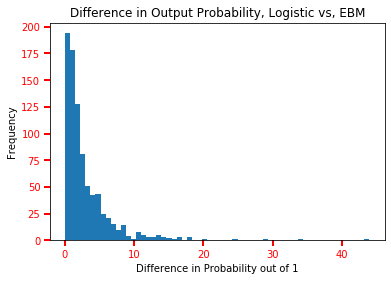

In [20]:
#plotting the absolute value
subtracted_absolute = [abs(100*(list_predicted_ebm-x)) for list_predicted_ebm, x in zip(list_predicted_ebm,x)]
fig, axn = plt.subplots()
axn.hist(subtracted_absolute, bins = 60)
axn.set_title('Difference in Output Probability, Logistic vs, EBM')
axn.set_ylabel('Frequency')
axn.set_xlabel('Difference in Probability out of 1')
#set_size(10,1)
axn.tick_params(direction='out', length=6, width=2, colors='r',
               grid_color='r', grid_alpha=2)

# These are the patients/samples with the greatest percentage difference in prediction

Text(0.5, 0, 'Difference in Probability out of 1')

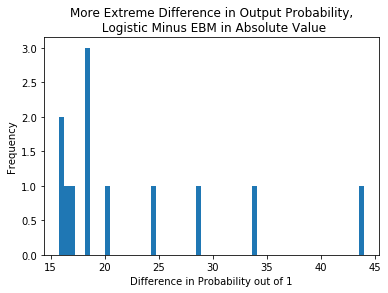

In [21]:
#plotting the absolute value
subtracted_absolute = [abs(100*(list_predicted_ebm-x)) if abs(100*(list_predicted_ebm-x))>10 else 0 for list_predicted_ebm, x in zip(list_predicted_ebm,x)]
#delete all the ones the filter passed over
#subtracted_absolute_greater_than = [subtracted_absolute
subtracted_absolute = [i for i in subtracted_absolute if i>15] 
fig, axn = plt.subplots()
axn.hist(subtracted_absolute, bins = 60)
axn.set_title('More Extreme Difference in Output Probability,\n Logistic Minus EBM in Absolute Value')
axn.set_ylabel('Frequency')
axn.set_xlabel('Difference in Probability out of 1')
#set_size(10,1)

# The rest does not apply to this experiment

In [22]:
#Converting the logits to Probability. Seems like they were already in probability........
#add index to the lists before 
#subtracteding and sort by biggest difference to identify which sample had the most disagreement

#did that first subtraction even make sense given that there is a nonlinear conversion to the probability?!!!
#you should convert to probablity before subtracting

#https://sebastiansauer.github.io/convert_logit2prob/

#have to round off floats to do the conversion
logit = -2
def to_probability(logit):
    try:
        for i in range(len(logit)):
            odds = math.exp(logit[i])
            prob = odds/ (1 + odds)
            logit[i] = prob
        return(logit)
    except:
        print("no")
print(type(newlist))
print(type(list_predicted_ebm))

<class 'list'>
<class 'list'>


In [23]:
#Model ensemble better?